In [1]:
# !pip install matplotlib
# !pip install scikit-learn
# !pip install scikit-fuzzy
#test

In [2]:
# ESSENTIALS
import numpy as np
import matplotlib.pyplot as plt

# CLUSTERING AND RANDOM FOREST
import skfuzzy as fuzz
import sklearn
from sklearn.datasets import make_blobs
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection

# DATA LIBRARIES
import geopandas as gpd
from glob import glob
import pandas as pd

# PREFERENCES
pd.set_option('display.max_columns', 500)

Generating Random Clusters for Testing

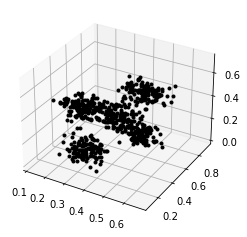

In [3]:
# Wrapper function for SKLearn MakeBlobs
def generateRandomFit(size, models, std = 0.05, center = (0.1, 0.9), n = 5):
    # Random state = 1 for reproducibility
    X, y = make_blobs(n_samples=size, cluster_std=std, center_box=center, centers=n, n_features=models, random_state=1)
    return X, y

X, y = generateRandomFit(671, 3)

ax = plt.axes(projection='3d')
ax.plot(X[:,0], X[:,1], X[:,2], '.k')

In [4]:
def plotClusters(X, labs, ncenters, ax):
    # Wraps a plotting function to return different colored clusters in a 3D axis
    colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']
    ax = plt.axes(projection='3d')
    for j in range(ncenters):
        ax.plot(X[labs == j, 0], X[labs == j, 1], X[labs==j, 1], '.', color=colors[j])
    return ax
        

def combine_rfs(rf_a, rf_b):
    # ADAPTED FROM https://stackoverflow.com/questions/28489667/combining-random-forest-models-in-scikit-learn
    rf_a.estimators_ += rf_b.estimators_
    rf_a.n_estimators = len(rf_a.estimators_)
    return rf_a

def combRFlist(rf_list):
    # GET FIRST RANDOM FOREST TREE FROM LIST, AND REMOVE IT FROM LIST
    fs = rf_list.pop()

    # LOOP THROUGH AND ADD, PER SOURCE ABOVE
    for rf in rf_list:
        fs = combine_rfs(fs, rf)
    
    return fs

def plotClusters(X, labs, ncenters, ax):
    # Wraps a plotting function to return different colored clusters in a 3D axis
    colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']
    ax = plt.axes(projection='3d')
    for j in range(ncenters):
        ax.plot(X[labs == j, 0], X[labs == j, 1], X[labs==j, 1], '.', color=colors[j])
    return ax
        
def fuzzyCluster(data, ncenters, m=2, stop=0.005, maxiter=1000):
    # Wraps Fuzzy Cluster function, only outputting percent belongs and formal cluster.
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data.T, ncenters, m, error=stop, maxiter=maxiter, init=None)
    label = np.argmax(u, axis=0)
    return u, label, fpc

def howManyClusters(X, mintest=2,maxtest=15):
    # Determines how many clusters should be used using the Fuzzy Partitions Coefficient (FPC)
    # https://scikit-fuzzy.github.io/scikit-fuzzy/auto_examples/plot_cmeans.html#example-plot-cmeans-py
    fpcs = []
    listtests = np.arange(mintest,maxtest)
    for ncenters in listtests:
        _, _, fpc = fuzzyCluster(X, ncenters)
        fpcs.append(fpc)
    plt.plot(listtests, fpcs)
    plt.xlabel("Number of Clusters")
    plt.ylabel("Fuzzy Partition Coefficient (FPC)")
    return listtests[np.argmax(fpcs)]



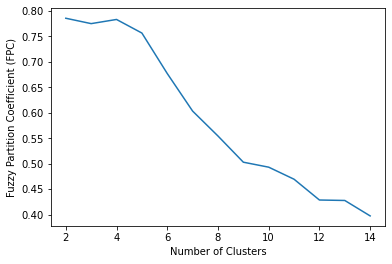

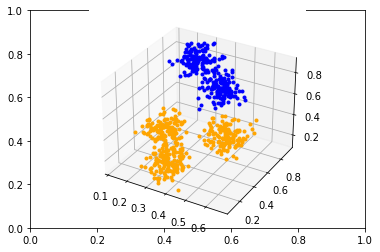

In [5]:
n_clusters = howManyClusters(X)
fig, ax = plt.subplots()    
_, labels, _ = fuzzyCluster(X, n_clusters)
ax = plotClusters(X, labels, n_clusters, ax)

Here we start importing the CAMELS dataset. First import and plot the shapefile. Let's also take a look at the attributes

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_KEA.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_KEA.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_KEA.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_KEA.dll
127: The specified procedure could not be found.



epsg:4269


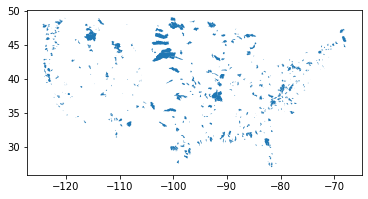

In [6]:
camelsdir = r"C:\Users\franc\OneDrive - University Of Houston\000_SIResearch\data\HCDN_nhru_final\HCDN_nhru_final_671.shp"

camels = gpd.read_file(camelsdir)
camels.plot()
print(camels.crs)

In [7]:
camels.head()

,hru_id,ann_P,lon_cen,lat_cen,AREA,elev_mean,ave_T,july_T,Perimeter,geometry
0,1013500,0.0,-68.56551,47.01169,2.303988e+09,277.493490,None,None,647993,"MULTIPOLYGON (((-68.35650 46.90311, -68.35612 ..."
1,1022500,0.0,-68.07313,44.79691,6.203873e+08,103.604200,None,None,312624,"POLYGON ((-67.97836 44.61310, -67.97800 44.613..."
2,1030500,0.0,-68.14985,45.80527,3.676155e+09,174.433896,None,None,662248,"MULTIPOLYGON (((-67.83991 45.36614, -67.83955 ..."
3,1031500,0.0,-69.58119,45.23568,7.665447e+08,304.743490,None,None,309614,"MULTIPOLYGON (((-69.33810 45.12317, -69.33800 ..."
4,1047000,0.0,-70.16213,44.98744,9.049562e+08,379.779978,None,None,310157,"POLYGON ((-70.10847 45.21669, -70.10858 45.216..."


As is evident from above, the attributes are kept separately. In fact, they are individual text files delimineted by a semicolon. We will point python to the directory they are kept, loop through them, and individually join them to the CAMELS shapefile.

In [8]:
attdir = r"C:\Users\franc\OneDrive - University Of Houston\000_SIResearch\data\camels_attributes_v2.0\camels_attributes_v2.0\\"

camels_df = camels # COPY TO KEEP ORIGINAL IN MEMORY

# PRIOR TO THIS STEP MAKE SURE THE README IN THE FILE SYSTEM HAS BEEN REMOVED (or the file extension has been changed)
filelist = glob(attdir + "*.txt")
for i in filelist:
    currdf = pd.read_csv(i, sep=";")
    camels_df = camels_df.merge(currdf, how='left', left_on="hru_id", right_on="gauge_id")

camels_df.head()


c:\Users\franc\anaconda3\envs\SITest\lib\site-packages\geopandas\geodataframe.py:1483: FutureWarning: Passing 'suffixes' which cause duplicate columns {'gauge_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)
c:\Users\franc\anaconda3\envs\SITest\lib\site-packages\geopandas\geodataframe.py:1483: FutureWarning: Passing 'suffixes' which cause duplicate columns {'gauge_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)


,hru_id,ann_P,lon_cen,lat_cen,AREA,elev_mean_x,ave_T,july_T,Perimeter,geometry,gauge_id_x,p_mean,pet_mean,p_seasonality,frac_snow,aridity,high_prec_freq,high_prec_dur,high_prec_timing,low_prec_freq,low_prec_dur,low_prec_timing,gauge_id_y,geol_1st_class,glim_1st_class_frac,geol_2nd_class,glim_2nd_class_frac,carbonate_rocks_frac,geol_porostiy,geol_permeability,gauge_id_x,q_mean,runoff_ratio,slope_fdc,baseflow_index,stream_elas,q5,q95,high_q_freq,high_q_dur,low_q_freq,low_q_dur,zero_q_freq,hfd_mean,gauge_id_y,huc_02,gauge_name,gauge_id_x,soil_depth_pelletier,soil_depth_statsgo,soil_porosity,soil_conductivity,max_water_content,sand_frac,silt_frac,clay_frac,water_frac,organic_frac,other_frac,gauge_id_y,gauge_lat,gauge_lon,elev_mean_y,slope_mean,area_gages2,area_geospa_fabric,gauge_id,frac_forest,lai_max,lai_diff,gvf_max,gvf_diff,dom_land_cover_frac,dom_land_cover,root_depth_50,root_depth_99
0,1013500,0.0,-68.56551,47.01169,2.303988e+09,277.493490,None,None,647993,"MULTIPOLYGON (((-68.35650 46.90311, -68.35612 ...",1013500,3.126679,1.971555,0.187940,0.313440,0.630559,12.95,1.348958,son,202.20,3.427119,mam,1013500,Siliciclastic sedimentary rocks,0.815904,Basic volcanic rocks,0.179729,0.000000,0.1714,-14.7019,1013500,1.699155,0.543437,1.528219,0.585226,1.845324,0.241106,6.373021,6.10,8.714286,41.35,20.170732,0.0,207.25,1013500,1,"Fish River near Fort Kent, Maine",1013500,7.404762,1.248408,0.461149,1.106522,0.558055,27.841827,55.156940,16.275732,5.376698,0.408717,0.000000,1013500,47.23739,-68.58264,250.31,21.64152,2252.70,2303.95,1013500,0.9063,4.167304,3.340732,0.804567,0.371648,0.883452,Mixed Forests,NaN,NaN
1,1022500,0.0,-68.07313,44.79691,6.203873e+08,103.604200,None,None,312624,"POLYGON ((-67.97836 44.61310, -67.97800 44.613...",1022500,3.608126,2.119256,-0.114530,0.245259,0.587356,20.55,1.205279,son,233.65,3.662226,jja,1022500,Acid plutonic rocks,0.590658,Siliciclastic sedimentary rocks,0.164618,0.000000,0.0710,-14.2138,1022500,2.173062,0.602269,1.776280,0.554478,1.702782,0.204734,7.123049,3.90,2.294118,65.15,17.144737,0.0,166.25,1022500,1,"Narraguagus River at Cherryfield, Maine",1022500,17.412808,1.491846,0.415905,2.375005,0.626229,59.390156,28.080937,12.037646,1.226913,0.000000,0.358472,1022500,44.60797,-67.93524,92.68,17.79072,573.60,620.38,1022500,0.9232,4.871392,3.746692,0.863936,0.337712,0.820493,Mixed Forests,0.237435,2.238444
2,1030500,0.0,-68.14985,45.80527,3.676155e+09,174.433896,None,None,662248,"MULTIPOLYGON (((-67.83991 45.36614, -67.83955 ...",1030500,3.274405,2.043594,0.047358,0.277018,0.624111,17.15,1.207746,son,215.60,3.514262,djf,1030500,Siliciclastic sedimentary rocks,0.573305,Metamorphics,0.287010,0.052140,0.1178,-14.4918,1030500,1.820108,0.555859,1.871110,0.508441,1.377505,0.107149,6.854887,12.25,7.205882,89.25,19.402174,0.0,184.90,1030500,1,"Mattawamkeag River near Mattawamkeag, Maine",1030500,19.011414,1.461363,0.459091,1.289807,0.653020,32.235458,51.779182,14.776824,1.634345,1.330278,0.022016,1030500,45.50097,-68.30596,143.80,12.79195,3676.17,3676.09,1030500,0.8782,4.685200,3.665543,0.858502,0.351393,0.975258,Mixed Forests,NaN,NaN
3,1031500,0.0,-69.58119,45.23568,7.665447e+08,304.743490,None,None,309614,"MULTIPOLYGON (((-69.33810 45.12317, -69.33800 ...",1031500,3.522957,2.071324,0.104091,0.291836,0.587950,18.90,1.148936,son,227.35,3.473644,djf,1031500,Siliciclastic sedimentary rocks,0.448928,Metamorphics,0.443863,0.026258,0.0747,-14.8410,1031500,2.030242,0.576289,1.494019,0.445091,1.648693,0.111345,8.010503,18.90,3.286957,94.80,14.697674,0.0,181.00,1031500,1,"Piscataquis River near Dover-Foxcroft, Maine",1031500,7.252557,1.279047,0.450236,1.373292,0.559123,35.269030,50.841232,12.654125,0.674594,0.000000,0.000000,1031500,45.17501,-69.31470,247.80,29.56035,769.05,766.53,1031500,0.9548,4.903259,3.990843,0.870668,0.398619,1.000000,Mixed Forests,0.250000,2.400000
4,1047000,0.0,-70.16213,44.98744,9.049562e+08,379.779978,None,None,310157,"POLYGON ((-70.10847 45.21669, -70.10858 45.216...",1047000,3.323146,2.090

Create input and output training datasets for random forest regression

In [9]:
# FIRST THING IS WE NEED TO CLEAN UP NONSENSICAL DATA (EG, BASIN LABELS)
# SO LETS GET A LIST OF VARIABLE NAMES WE WANT TO KEEP.

# TO START WE WILL KEEP THE SAME VARIABLES AS Kratzert et al. 2019, AS SHOWN BY OUR
# INTERNAL SPREADSHEET Attributes_CAMELS_vs_NHDPlus
varstokeep = ['p_mean',
'pet_mean',
'aridity',
'p_seasonality',
'frac_snow',                   # In spreadsheet as 'frac_snow_daily'
'high_prec_freq',
'high_prec_dur',
'low_prec_freq',
'low_prec_dur',
'elev_mean_x',                 # In spreadsheet as 'elev_mean' 
'slope_mean',
'area_gages2',
'frac_forest',                 # In spreadsheet as 'forest_frac'
'lai_max',
'lai_diff',
'gvf_max',
'gvf_diff',
'soil_depth_pelletier',
'soil_depth_statsgo',
'soil_porosity',
'soil_conductivity',
'max_water_content',
'sand_frac',
'silt_frac',
'clay_frac',
'carbonate_rocks_frac',         # In spreadsheet as 'carb_rocks_frac'
'geol_permeability']

# DO NOT DELETE!!! ---------------------------------------------------------------------------------------------
# CHECK OUR VALUES ARE GOOD
tflist = []
for i in varstokeep: # LOOP THROUGH AND CHECK COLUMN NAME IS IN DATAFRAME, STORE RESULT IN TFLIST
    tflist.append(i in camels_df)

# CONVERT TF LIST TO NUMPY ARRAY, THEN CHECK IF ALL ARE TRUE. IF NOT, PRINT WHICH ONE ISN'T AND RAISE EXCEPTION
tflist = np.array(tflist)
if np.any(np.logical_not(tflist)):
    print("\n".join(np.array(varstokeep)[np.logical_not(tflist)]))
    raise(Exception("Printed values not in CAMELS DataFrame"))
# ---------------------------------------------------------------------------------------------------------------

inputdataset = camels_df[varstokeep]
outputdataset = X # TODO: ONCE WE GET THE REAL PERFORMANCE METRICS, MODIFY ACCORDINGLY

Test fitting with Random Forest

In [10]:
clf = RandomForestRegressor()

clf.fit(inputdataset, outputdataset)

RandomForestRegressor()

In [13]:
clf.score(inputdataset, outputdataset)

0.8453681285525493

<BarContainer object of 27 artists>

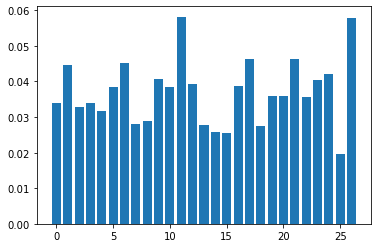

In [14]:
plt.bar(np.arange(0, len(varstokeep)), clf.feature_importances_)